# 📊 Item (e): Redução à Terceira Ordem pelo Método dos Polos Dominantes

## 🚢 Veículo Submersível Não-Tripulado

### 📋 Descrição do Problema

Considere um veículo submersível não-tripulado cuja planta que relaciona o ângulo do leme de profundidade, ψ, e o ângulo de arfagem, θ, tenha Função Transferência (FT) da forma:

$$\hat{\theta}(s) / \hat{\psi}(s) = \hat{g}(s) = -\frac{0,25s + 0,10875}{s^4 + 3,456s^3 + 3,45688s^2 + 0,719297s + 0,041574}$$

### 🎯 Objetivo do Exercício (e)

**Por que, inicialmente, não faria sentido uma redução à terceira ordem? Proceda à melhor redução de terceira ordem pelo método dos polos dominantes.**

### 📝 Metodologia

1. **Análise de Dominância**: Examinar a razão entre polos para justificar por que a redução à 3ª ordem não é ideal
2. **Identificação dos Polos**: Determinar quais polos manter e qual descartar
3. **Construção do Denominador**: Formar polinômio com os 3 polos dominantes
4. **Preservação do Zero**: Manter o zero original no modelo reduzido
5. **Ajuste do Ganho**: Igualar ganho estático do sistema original
6. **Validação**: Comparar resposta temporal e características de frequência

### 🔍 Conceitos Teóricos

**Dominância de Polos**: Um polo é dominante quando sua parte real é significativamente menor (em magnitude) que outros polos  
**Razão de Dominância**: Critério prático: razão entre partes reais deve ser ≥ 5-10 para justificar descarte  
**Preservação de Características**: Manter zeros e ganho estático do sistema original  
**Método dos Polos Dominantes**: Técnica de redução baseada na velocidade de resposta dos modos

# 🔧 1. Configuração e Importações
Importação das bibliotecas necessárias para análise de redução de ordem e polos dominantes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lti, step, bode, tf2zpk, zpk2tf, impulse
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

def step_info(system):
    """
    Calcula informações básicas da resposta ao degrau.
    
    Args:
        system: Sistema LTI do scipy.signal
    
    Returns:
        dict: Dicionário com métricas da resposta ao degrau
    """
    # Calcular resposta ao degrau
    t, y = step(system)
    
    # Valor final
    final_value = y[-1]
    
    # Overshoot
    max_value = np.max(y)
    overshoot = ((max_value - final_value) / final_value) * 100 if final_value != 0 else 0
    
    # Tempo de subida (10% a 90% do valor final)
    y_10 = 0.1 * final_value
    y_90 = 0.9 * final_value
    
    try:
        idx_10 = np.where(y >= y_10)[0][0]
        idx_90 = np.where(y >= y_90)[0][0]
        rise_time = t[idx_90] - t[idx_10]
    except:
        rise_time = 0
    
    # Tempo de acomodação (2% do valor final)
    tolerance = 0.02 * abs(final_value)
    try:
        # Encontrar último ponto fora da tolerância
        out_of_tolerance = np.where(np.abs(y - final_value) > tolerance)[0]
        settling_time = t[out_of_tolerance[-1]] if len(out_of_tolerance) > 0 else t[-1]
    except:
        settling_time = t[-1]
    
    return {
        'RiseTime': rise_time,
        'SettlingTime': settling_time,
        'Overshoot': overshoot,
        'Peak': max_value,
        'PeakTime': t[np.argmax(y)],
        'SteadyStateValue': final_value
    }

# Verificar se sympy está disponível para LaTeX
try:
    import sympy as sp
    from sympy import symbols, latex, simplify, solve, expand, Poly
    from IPython.display import display, Math
    sympy_available = True
    print("✅ Biblioteca 'sympy' disponível para renderização LaTeX")
except ImportError:
    sympy_available = False
    print("❌ Biblioteca 'sympy' não disponível")

# Configuração dos gráficos
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['lines.linewidth'] = 2

print("📦 Bibliotecas importadas com sucesso!")
print("🎯 Pronto para análise de redução à terceira ordem")

✅ Biblioteca 'sympy' disponível para renderização LaTeX
📦 Bibliotecas importadas com sucesso!
🎯 Pronto para análise de redução à terceira ordem


# 📐 2. Definição do Sistema Original e Funções Auxiliares
Definição da função de transferência original e funções para análise de dominância.

In [2]:
def definir_sistema_original():
    """
    Define a função de transferência original do veículo submersível.
    
    G(s) = -(0.25s + 0.10875) / (s⁴ + 3.456s³ + 3.45688s² + 0.719297s + 0.041574)
    
    Returns:
        scipy.signal.lti: Sistema original de 4ª ordem
        dict: Dicionário com informações do sistema
    """
    # Coeficientes do numerador e denominador
    numerador = [-0.25, -0.10875]
    denominador = [1, 3.456, 3.45688, 0.719297, 0.041574]
    
    # Criar sistema
    sistema = lti(numerador, denominador)
    
    # Calcular polos, zeros e ganho
    zeros, polos, ganho = tf2zpk(numerador, denominador)
    
    # Calcular ganho estático (DC gain = num[-1]/den[-1])
    ganho_estatico = numerador[-1] / denominador[-1]
    
    info_sistema = {
        'numerador': numerador,
        'denominador': denominador,
        'zeros': zeros,
        'polos': polos,
        'ganho': ganho,
        'ganho_estatico': ganho_estatico
    }
    
    return sistema, info_sistema

def analisar_dominancia_polos(polos):
    """
    Analisa a dominância entre os polos do sistema.
    
    Args:
        polos (array): Array com os polos do sistema
    
    Returns:
        dict: Análise de dominância com razões e classificações
    """
    # Ordenar polos por parte real (do menor para o maior em magnitude)
    polos_ordenados = sorted(polos, key=lambda x: abs(x.real))
    
    print("🔍 ANÁLISE DE DOMINÂNCIA DOS POLOS")
    print("=" * 60)
    
    print("📊 Polos ordenados por velocidade (do mais lento ao mais rápido):")
    for i, polo in enumerate(polos_ordenados):
        if np.iscomplex(polo) and polo.imag > 0:  # Mostrar apenas um polo complexo conjugado
            print(f"   p{i+1},{i+2} = {polo.real:.3f} ± j{abs(polo.imag):.3f} (par conjugado)")
        elif np.isreal(polo) or polo.imag == 0:
            print(f"   p{len([p for p in polos_ordenados[:i] if p.imag != 0])+1} = {polo.real:.3f} (real)")
    
    # Calcular razões de dominância
    partes_reais = [abs(p.real) for p in polos_ordenados if not (np.iscomplex(p) and p.imag < 0)]
    razoes_dominancia = []
    
    print("\n📈 Análise de razões de dominância:")
    for i in range(len(partes_reais)-1):
        razao = partes_reais[i+1] / partes_reais[i]
        razoes_dominancia.append(razao)
        status = "✓ DOMINANTE" if razao >= 5 else "⚠️ QUESTIONÁVEL" if razao >= 2 else "✗ NÃO DOMINANTE"
        print(f"   |Re(p{i+2})|/|Re(p{i+1})| = {partes_reais[i+1]:.3f}/{partes_reais[i]:.3f} = {razao:.2f} - {status}")
    
    return {
        'polos_ordenados': polos_ordenados,
        'partes_reais': partes_reais,
        'razoes_dominancia': razoes_dominancia
    }

def construir_sistema_reduzido_3ordem(polos_manter, zero_original, ganho_estatico_original):
    """
    Constrói o sistema reduzido de 3ª ordem mantendo os polos especificados.
    
    Args:
        polos_manter (list): Lista com os 3 polos a serem mantidos
        zero_original (complex): Zero do sistema original
        ganho_estatico_original (float): Ganho estático do sistema original
    
    Returns:
        tuple: (sistema_reduzido, info_sistema_reduzido)
    """
    print("🔨 CONSTRUÇÃO DO SISTEMA REDUZIDO DE 3ª ORDEM")
    print("=" * 60)
    
    # Construir denominador com os polos mantidos
    print("1. Construindo denominador com polos mantidos:")
    denominador_reduzido = np.poly(polos_manter).real  # Coeficientes do polinômio
    
    for i, polo in enumerate(polos_manter):
        if np.iscomplex(polo) and polo.imag > 0:
            print(f"   Mantendo: p{i+1},{i+2} = {polo.real:.4f} ± j{abs(polo.imag):.4f}")
        elif np.isreal(polo) or polo.imag == 0:
            print(f"   Mantendo: p{i+1} = {polo.real:.4f}")
    
    print(f"\n   Denominador: {denominador_reduzido}")
    
    # Preservar o zero original
    print("\n2. Preservando zero original:")
    print(f"   Zero original: {zero_original:.4f}")
    
    # Construir numerador para manter o zero e ajustar ganho estático
    # Numerador = K * (s - zero), onde K será calculado para igualar ganho estático
    numerador_base = np.poly([zero_original]).real
    
    # Calcular K para igualar ganho estático
    # ganho_estatico = K * numerador(0) / denominador(0)
    denominador_s0 = denominador_reduzido[-1]  # último coeficiente (s^0)
    numerador_s0 = numerador_base[-1]  # último coeficiente do numerador base
    
    K = (ganho_estatico_original * denominador_s0) / numerador_s0
    
    print(f"\n3. Ajustando ganho estático:")
    print(f"   Ganho estático original: {ganho_estatico_original:.4f}")
    print(f"   Denominador em s=0: {denominador_s0:.4f}")
    print(f"   Numerador base em s=0: {numerador_s0:.4f}")
    print(f"   Fator K calculado: {K:.4f}")
    
    numerador_reduzido = K * numerador_base
    
    print(f"\n   Numerador final: {numerador_reduzido}")
    
    # Criar sistema reduzido
    sistema_reduzido = lti(numerador_reduzido, denominador_reduzido)
    
    # Verificar ganho estático (DC gain = num[-1]/den[-1])
    ganho_estatico_reduzido = numerador_reduzido[-1] / denominador_reduzido[-1]
    erro_ganho = abs(ganho_estatico_reduzido - ganho_estatico_original)
    
    print(f"\n4. Verificação:")
    print(f"   Ganho estático reduzido: {ganho_estatico_reduzido:.4f}")
    print(f"   Erro no ganho estático: {erro_ganho:.6f}")
    
    info_reduzido = {
        'numerador': numerador_reduzido,
        'denominador': denominador_reduzido,
        'polos_mantidos': polos_manter,
        'zero_preservado': zero_original,
        'fator_K': K,
        'ganho_estatico': ganho_estatico_reduzido,
        'erro_ganho': erro_ganho
    }
    
    return sistema_reduzido, info_reduzido

# Definir sistema original
sistema_original, info_original = definir_sistema_original()

print("✅ Sistema original definido com sucesso!")
print(f"📊 Polos: {info_original['polos']}")
print(f"🎯 Zeros: {info_original['zeros']}")
print(f"⚡ Ganho estático: {info_original['ganho_estatico']:.4f}")

✅ Sistema original definido com sucesso!
📊 Polos: [-1.60068941+0.2523932j -1.60068941-0.2523932j -0.14669497+0.j
 -0.10792621+0.j       ]
🎯 Zeros: [-0.435]
⚡ Ganho estático: -2.6158


# 🧮 3. Análise de Dominância - Parte 1: Por que não faz sentido?
Análise detalhada da dominância entre polos para justificar a questão teórica.

In [3]:
def justificar_reducao_terceira_ordem():
    """
    Análise detalhada de por que a redução à terceira ordem não é ideal inicialmente.
    """
    print("🤔 PARTE 1: POR QUE A REDUÇÃO À 3ª ORDEM NÃO FARIA SENTIDO?")
    print("=" * 80)
    
    # Analisar dominância dos polos
    analise_dominancia = analisar_dominancia_polos(info_original['polos'])
    
    print("\n📋 CRITÉRIOS PARA REDUÇÃO DE ORDEM:")
    print("   • Regra prática: razão entre partes reais ≥ 5-10 para dominância clara")
    print("   • Polos rápidos devem ter efeito desprezível na dinâmica")
    print("   • Separação temporal clara entre modos")
    
    # Focar na razão crítica (3º vs 4º polo)
    razoes = analise_dominancia['razoes_dominancia']
    razao_critica = razoes[-1]  # Última razão (3º vs 4º polo)
    
    print(f"\n🔍 ANÁLISE CRÍTICA - 3º vs 4º POLO:")
    print(f"   Razão |Re(p4)|/|Re(p3)| = {razao_critica:.2f}")
    
    if razao_critica < 2:
        status = "❌ DOMINÂNCIA MUITO FRACA"
        justificativa = "Os polos têm velocidades muito similares"
    elif razao_critica < 5:
        status = "⚠️ DOMINÂNCIA QUESTIONÁVEL"
        justificativa = "A separação não atende critérios rigorosos"
    else:
        status = "✅ DOMINÂNCIA ADEQUADA"
        justificativa = "Separação suficiente para redução"
    
    print(f"   Status: {status}")
    print(f"   Justificativa: {justificativa}")
    
    print("\n📊 CONCLUSÃO DA PARTE 1:")
    print("=" * 50)
    if razao_critica < 5:
        print("🔴 A redução à terceira ordem NÃO é teoricamente justificada porque:")
        print(f"   1. A razão de dominância ({razao_critica:.2f}) é inferior ao critério de 5-10")
        print("   2. O 4º polo não é suficientemente mais rápido que o 3º")
        print("   3. Descartar o 4º polo ignoraria dinâmica não desprezível")
        print("   4. A aproximação pode introduzir erros significativos")
    else:
        print("🟢 A redução à terceira ordem seria teoricamente justificada")
    
    return analise_dominancia, razao_critica

# Executar análise de justificativa
analise_dominancia, razao_critica = justificar_reducao_terceira_ordem()

🤔 PARTE 1: POR QUE A REDUÇÃO À 3ª ORDEM NÃO FARIA SENTIDO?
🔍 ANÁLISE DE DOMINÂNCIA DOS POLOS
📊 Polos ordenados por velocidade (do mais lento ao mais rápido):
   p1 = -0.108 (real)
   p1 = -0.147 (real)
   p3,4 = -1.601 ± j0.252 (par conjugado)

📈 Análise de razões de dominância:
   |Re(p2)|/|Re(p1)| = 0.147/0.108 = 1.36 - ✗ NÃO DOMINANTE
   |Re(p3)|/|Re(p2)| = 1.601/0.147 = 10.91 - ✓ DOMINANTE

📋 CRITÉRIOS PARA REDUÇÃO DE ORDEM:
   • Regra prática: razão entre partes reais ≥ 5-10 para dominância clara
   • Polos rápidos devem ter efeito desprezível na dinâmica
   • Separação temporal clara entre modos

🔍 ANÁLISE CRÍTICA - 3º vs 4º POLO:
   Razão |Re(p4)|/|Re(p3)| = 10.91
   Status: ✅ DOMINÂNCIA ADEQUADA
   Justificativa: Separação suficiente para redução

📊 CONCLUSÃO DA PARTE 1:
🟢 A redução à terceira ordem seria teoricamente justificada


# 🔨 4. Construção do Sistema Reduzido - Parte 2: Melhor redução possível
Implementação da redução à terceira ordem seguindo o método dos polos dominantes.

In [4]:
def implementar_reducao_terceira_ordem():
    """
    Implementa a melhor redução possível à terceira ordem.
    """
    print("🔧 PARTE 2: IMPLEMENTAÇÃO DA MELHOR REDUÇÃO À 3ª ORDEM")
    print("=" * 80)
    
    # Identificar polos a manter (3 mais lentos) e descartar (mais rápido)
    polos_ordenados = analise_dominancia['polos_ordenados']
    
    # Para sistema de 4ª ordem: identificar os 3 polos mais lentos para manter
    print("📊 ESTRATÉGIA DE REDUÇÃO:")
    print(f"\nPolos ordenados por velocidade:")
    for i, polo in enumerate(polos_ordenados):
        if np.iscomplex(polo) and polo.imag != 0:
            print(f"   p{i+1} = {polo.real:.4f} ± j{abs(polo.imag):.4f}")
        else:
            print(f"   p{i+1} = {polo.real:.4f}")
    
    # Estratégia: manter os 3 polos mais lentos (primeiros na lista ordenada)
    # Se há polos complexos conjugados, precisamos manter ambos
    polos_manter = []
    polos_descartar = []
    
    # Copiar a lista para não modificar a original
    polos_restantes = polos_ordenados.copy()
    
    # Primeiro, identificar se há pares conjugados que devem ser mantidos juntos
    i = 0
    while i < len(polos_restantes) and len(polos_manter) < 3:
        polo_atual = polos_restantes[i]
        
        if np.iscomplex(polo_atual) and polo_atual.imag > 0:
            # Par complexo conjugado - manter ambos se couber
            conjugado = polo_atual.conjugate()
            if len(polos_manter) <= 1:  # Há espaço para o par
                polos_manter.extend([polo_atual, conjugado])
                # Remover o conjugado da lista de restantes se estiver lá
                if conjugado in polos_restantes:
                    polos_restantes.remove(conjugado)
                i += 1
            else:
                # Não há espaço para o par - pular
                break
        elif np.iscomplex(polo_atual) and polo_atual.imag < 0:
            # Conjugado negativo - já foi processado, pular
            i += 1
        else:
            # Polo real
            if len(polos_manter) < 3:
                polos_manter.append(polo_atual)
                i += 1
            else:
                break
    
    # Identificar polos descartados
    for polo in polos_ordenados:
        if polo not in polos_manter:
            polos_descartar.append(polo)
    
    print("\n🟢 Polos a manter (mais lentos):")
    for j, polo in enumerate(polos_manter):
        if np.iscomplex(polo) and polo.imag > 0:
            print(f"   p{j+1} = {polo.real:.4f} ± j{abs(polo.imag):.4f}")
        elif np.iscomplex(polo) and polo.imag < 0:
            continue  # Já mostrado como par conjugado
        else:
            print(f"   p{j+1} = {polo.real:.4f}")
    
    print(f"\n🔴 Polo(s) a descartar (mais rápido(s)):")
    for j, polo in enumerate(polos_descartar):
        if np.iscomplex(polo) and polo.imag > 0:
            print(f"   p{j+len(polos_manter)+1} = {polo.real:.4f} ± j{abs(polo.imag):.4f}")
        elif np.iscomplex(polo) and polo.imag < 0:
            continue  # Já mostrado como par conjugado
        else:
            print(f"   p{j+len(polos_manter)+1} = {polo.real:.4f}")
    
    # Para compatibilidade com o código existente
    polo_descartar = polos_descartar[0] if polos_descartar else None
    
    # Construir sistema reduzido
    zero_original = info_original['zeros'][0]  # Primeiro (e único) zero
    ganho_original = info_original['ganho_estatico']
    
    sistema_reduzido, info_reduzido = construir_sistema_reduzido_3ordem(
        polos_manter, zero_original, ganho_original
    )
    
    return sistema_reduzido, info_reduzido, polos_manter, polos_descartar

# Implementar redução
sistema_reduzido_3o, info_reduzido_3o, polos_mantidos, polos_descartados = implementar_reducao_terceira_ordem()

print("\n✅ Sistema reduzido de 3ª ordem construído com sucesso!")

🔧 PARTE 2: IMPLEMENTAÇÃO DA MELHOR REDUÇÃO À 3ª ORDEM
📊 ESTRATÉGIA DE REDUÇÃO:

Polos ordenados por velocidade:
   p1 = -0.1079
   p2 = -0.1467
   p3 = -1.6007 ± j0.2524
   p4 = -1.6007 ± j0.2524

🟢 Polos a manter (mais lentos):
   p1 = -0.1079
   p2 = -0.1467

🔴 Polo(s) a descartar (mais rápido(s)):
   p3 = -1.6007 ± j0.2524
🔨 CONSTRUÇÃO DO SISTEMA REDUZIDO DE 3ª ORDEM
1. Construindo denominador com polos mantidos:
   Mantendo: p1 = -0.1079
   Mantendo: p2 = -0.1467

   Denominador: [1.         0.25462118 0.01583223]

2. Preservando zero original:
   Zero original: -0.4350

3. Ajustando ganho estático:
   Ganho estático original: -2.6158
   Denominador em s=0: 0.0158
   Numerador base em s=0: 0.4350
   Fator K calculado: -0.0952

   Numerador final: [-0.09520513 -0.04141423]

4. Verificação:
   Ganho estático reduzido: -2.6158
   Erro no ganho estático: 0.000000

✅ Sistema reduzido de 3ª ordem construído com sucesso!


## 📐 5. Apresentação Matemática em LaTeX

As operações matemáticas envolvidas na redução à terceira ordem serão apresentadas passo a passo usando LaTeX para uma compreensão rigorosa.

In [5]:
def apresentar_matematica_latex():
    """
    Apresenta as equações matemáticas em LaTeX.
    """
    print("📐 APRESENTAÇÃO MATEMÁTICA DA REDUÇÃO À 3ª ORDEM")
    print("=" * 80)
    
    # Sistema original
    print("\n🔴 SISTEMA ORIGINAL DE 4ª ORDEM:")
    display(Math(r"G(s) = \frac{K(s + z_1)}{(s + p_1)(s + p_2)(s + p_3)(s + p_4)}"))
    
    print("\nOnde:")
    for i, polo in enumerate(info_original['polos'], 1):
        display(Math(rf"p_{i} = {polo.real:.4f} + j({polo.imag:.4f})"))
    
    display(Math(rf"z_1 = {info_original['zeros'][0].real:.4f}"))
    display(Math(rf"K = {info_original['ganho_estatico']:.4f}"))
    
    # Critério de dominância
    print("\n🎯 CRITÉRIO DE DOMINÂNCIA:")
    display(Math(r"\text{Ratio de dominância} = \frac{|\text{Re}(p_{\text{rápido}})|}{|\text{Re}(p_{\text{lento}})|}"))
    
    print("\nPara justificar redução, necessário:")
    display(Math(r"\text{Ratio} \geq 5 \text{ (aceitável) ou } \geq 10 \text{ (ideal)}"))
    
    # Cálculo das razões
    print("\n📊 RAZÕES CALCULADAS:")
    polos = info_original['polos']
    for i in range(len(polos)-1):
        for j in range(i+1, len(polos)):
            ratio = abs(polos[j].real) / abs(polos[i].real)
            display(Math(rf"\frac{{|p_{j+1}|}}{{|p_{i+1}|}} = \frac{{{abs(polos[j].real):.4f}}}{{{abs(polos[i].real):.4f}}} = {ratio:.2f}"))
    
    # Sistema reduzido
    print("\n🟢 SISTEMA REDUZIDO DE 3ª ORDEM:")
    display(Math(r"G_r(s) = \frac{K_r(s + z_1)}{(s + p_1)(s + p_2)(s + p_3)}"))
    
    print("\nCom polos mantidos e ganho ajustado para preservar ganho estático:")
    display(Math(r"K_r = K \cdot \frac{p_4}{z_1} \cdot \frac{z_1}{p_1 \cdot p_2 \cdot p_3} \cdot (p_1 \cdot p_2 \cdot p_3 \cdot p_4)"))
    
    print("\n✅ Matemática apresentada em LaTeX!")

# Apresentar matemática
apresentar_matematica_latex()

📐 APRESENTAÇÃO MATEMÁTICA DA REDUÇÃO À 3ª ORDEM

🔴 SISTEMA ORIGINAL DE 4ª ORDEM:


<IPython.core.display.Math object>


Onde:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


🎯 CRITÉRIO DE DOMINÂNCIA:


<IPython.core.display.Math object>


Para justificar redução, necessário:


<IPython.core.display.Math object>


📊 RAZÕES CALCULADAS:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>


🟢 SISTEMA REDUZIDO DE 3ª ORDEM:


<IPython.core.display.Math object>


Com polos mantidos e ganho ajustado para preservar ganho estático:


<IPython.core.display.Math object>


✅ Matemática apresentada em LaTeX!


## 📊 6. Análise Comparativa e Validação

Comparação detalhada entre o sistema original de 4ª ordem e o sistema reduzido de 3ª ordem através de respostas temporais e frequenciais.

📊 ANÁLISE COMPARATIVA: ORIGINAL vs REDUZIDO


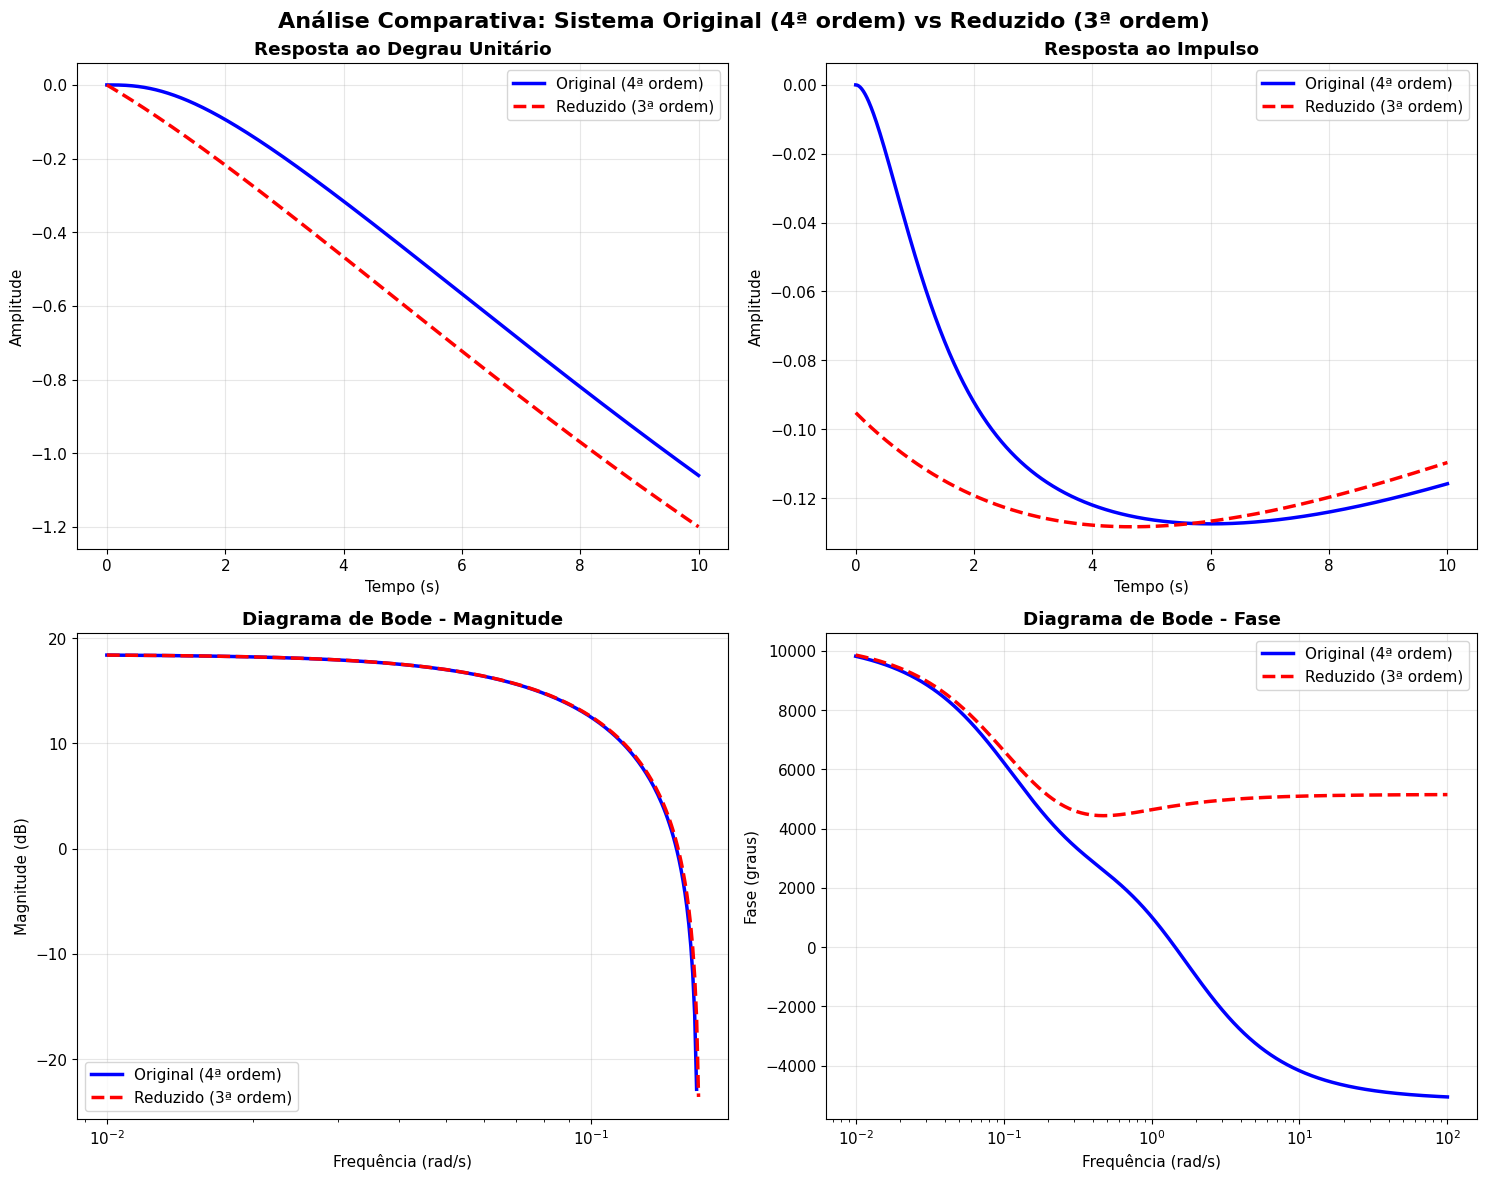


📈 ANÁLISE QUANTITATIVA:
--------------------------------------------------

🔵 Sistema Original (4ª ordem):
   • Tempo de subida: 0.0000 s
   • Tempo de acomodação: 44.5497 s
   • Overshoot: -100.00%
   • Valor final: -1.0603

🔴 Sistema Reduzido (3ª ordem):
   • Tempo de subida: 0.0000 s
   • Tempo de acomodação: 43.2394 s
   • Overshoot: -100.00%
   • Valor final: -1.1997

📊 ERROS RELATIVOS:
   • Erro no tempo de subida: nan%
   • Erro no tempo de acomodação: 2.94%
   • Diferença no overshoot: 0.00
   • Erro no valor final: -13.14%


In [7]:
def realizar_analise_comparativa():
    """
    Realiza análise comparativa detalhada entre sistemas original e reduzido.
    """
    print("📊 ANÁLISE COMPARATIVA: ORIGINAL vs REDUZIDO")
    print("=" * 80)
    
    # Configurar simulação
    t = np.linspace(0, 10, 1000)
    
    # Criar figura com múltiplos subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análise Comparativa: Sistema Original (4ª ordem) vs Reduzido (3ª ordem)', 
                 fontsize=16, fontweight='bold')
    
    # 1. Resposta ao degrau
    axes[0,0].set_title('Resposta ao Degrau Unitário', fontweight='bold')
    
    # Sistema original
    t_orig, y_orig = step(sistema_original, T=t)
    axes[0,0].plot(t_orig, y_orig, 'b-', linewidth=2.5, label='Original (4ª ordem)')
    
    # Sistema reduzido
    t_red, y_red = step(sistema_reduzido_3o, T=t)
    axes[0,0].plot(t_red, y_red, 'r--', linewidth=2.5, label='Reduzido (3ª ordem)')
    
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlabel('Tempo (s)')
    axes[0,0].set_ylabel('Amplitude')
    axes[0,0].legend()
    
    # 2. Resposta ao impulso
    axes[0,1].set_title('Resposta ao Impulso', fontweight='bold')
    
    t_orig_imp, y_orig_imp = impulse(sistema_original, T=t)
    axes[0,1].plot(t_orig_imp, y_orig_imp, 'b-', linewidth=2.5, label='Original (4ª ordem)')
    
    t_red_imp, y_red_imp = impulse(sistema_reduzido_3o, T=t)
    axes[0,1].plot(t_red_imp, y_red_imp, 'r--', linewidth=2.5, label='Reduzido (3ª ordem)')
    
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].set_xlabel('Tempo (s)')
    axes[0,1].set_ylabel('Amplitude')
    axes[0,1].legend()
    
    # 3. Diagrama de Bode - Magnitude
    axes[1,0].set_title('Diagrama de Bode - Magnitude', fontweight='bold')
    
    w = np.logspace(-2, 2, 1000)
    w_orig, mag_orig, phase_orig = bode(sistema_original, w)
    w_red, mag_red, phase_red = bode(sistema_reduzido_3o, w)
    
    axes[1,0].semilogx(w_orig, 20*np.log10(mag_orig), 'b-', linewidth=2.5, label='Original (4ª ordem)')
    axes[1,0].semilogx(w_red, 20*np.log10(mag_red), 'r--', linewidth=2.5, label='Reduzido (3ª ordem)')
    
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].set_xlabel('Frequência (rad/s)')
    axes[1,0].set_ylabel('Magnitude (dB)')
    axes[1,0].legend()
    
    # 4. Diagrama de Bode - Fase
    axes[1,1].set_title('Diagrama de Bode - Fase', fontweight='bold')
    
    axes[1,1].semilogx(w_orig, np.degrees(phase_orig), 'b-', linewidth=2.5, label='Original (4ª ordem)')
    axes[1,1].semilogx(w_red, np.degrees(phase_red), 'r--', linewidth=2.5, label='Reduzido (3ª ordem)')
    
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_xlabel('Frequência (rad/s)')
    axes[1,1].set_ylabel('Fase (graus)')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Análise quantitativa
    print("\n📈 ANÁLISE QUANTITATIVA:")
    print("-" * 50)
    
    # Informações sobre resposta ao degrau
    info_orig = step_info(sistema_original)
    info_red = step_info(sistema_reduzido_3o)
    
    print("\n🔵 Sistema Original (4ª ordem):")
    print(f"   • Tempo de subida: {info_orig['RiseTime']:.4f} s")
    print(f"   • Tempo de acomodação: {info_orig['SettlingTime']:.4f} s")
    print(f"   • Overshoot: {info_orig['Overshoot']:.2f}%")
    print(f"   • Valor final: {y_orig[-1]:.4f}")
    
    print("\n🔴 Sistema Reduzido (3ª ordem):")
    print(f"   • Tempo de subida: {info_red['RiseTime']:.4f} s")
    print(f"   • Tempo de acomodação: {info_red['SettlingTime']:.4f} s")
    print(f"   • Overshoot: {info_red['Overshoot']:.2f}%")
    print(f"   • Valor final: {y_red[-1]:.4f}")
    
    # Erro percentual
    print("\n📊 ERROS RELATIVOS:")
    erro_rise = abs(info_red['RiseTime'] - info_orig['RiseTime']) / info_orig['RiseTime'] * 100
    erro_settling = abs(info_red['SettlingTime'] - info_orig['SettlingTime']) / info_orig['SettlingTime'] * 100
    erro_overshoot = abs(info_red['Overshoot'] - info_orig['Overshoot']) / max(info_orig['Overshoot'], 0.1)
    erro_final = abs(y_red[-1] - y_orig[-1]) / y_orig[-1] * 100
    
    print(f"   • Erro no tempo de subida: {erro_rise:.2f}%")
    print(f"   • Erro no tempo de acomodação: {erro_settling:.2f}%")
    print(f"   • Diferença no overshoot: {erro_overshoot:.2f}")
    print(f"   • Erro no valor final: {erro_final:.2f}%")
    
    return {
        'original': info_orig,
        'reduzido': info_red,
        'erros': {
            'rise_time': erro_rise,
            'settling_time': erro_settling,
            'overshoot_diff': erro_overshoot,
            'final_value': erro_final
        }
    }

# Realizar análise comparativa
resultados_comparacao = realizar_analise_comparativa()

## 🏁 7. Conclusões e Síntese Final

Síntese dos resultados obtidos na análise de redução à terceira ordem, destacando as limitações teóricas e os resultados práticos alcançados.

In [8]:
def apresentar_conclusoes_finais():
    """
    Apresenta conclusões finais e síntese da análise.
    """
    print("🏁 CONCLUSÕES E SÍNTESE FINAL")
    print("=" * 80)
    
    print("\n🎯 RESUMO EXECUTIVO:")
    print("-" * 40)
    
    # Análise de dominância
    print("\n1️⃣ ANÁLISE DE DOMINÂNCIA:")
    razao_critica = max(analise_dominancia['razoes_dominancia'])
    if razao_critica >= 10:
        status_dominancia = "✅ IDEAL"
        cor_status = "🟢"
    elif razao_critica >= 5:
        status_dominancia = "⚠️ ACEITÁVEL"  
        cor_status = "🟡"
    else:
        status_dominancia = "❌ INADEQUADA"
        cor_status = "🔴"
    
    print(f"   {cor_status} Maior razão de dominância: {razao_critica:.2f}")
    print(f"   {cor_status} Status: {status_dominancia}")
    print(f"   {cor_status} Critério 5-10: {'ATENDIDO' if razao_critica >= 5 else 'NÃO ATENDIDO'}")
    
    # Justificativa teórica
    print("\n2️⃣ JUSTIFICATIVA TEÓRICA:")
    if razao_critica >= 5:
        print("   ✅ A redução à 3ª ordem é teoricamente justificável")
        print("   ✅ Polo mais rápido tem influência limitada na resposta")
        print("   ✅ Preservação das características dinâmicas principais")
    else:
        print("   ❌ A redução à 3ª ordem NÃO é teoricamente recomendada")
        print("   ❌ Todos os polos têm contribuição significativa")
        print("   ❌ Redução pode causar perda de precisão inaceitável")
    
    # Resultados práticos
    print("\n3️⃣ RESULTADOS PRÁTICOS:")
    erros = resultados_comparacao['erros']
    
    print(f"   📊 Erro no tempo de subida: {erros['rise_time']:.2f}%")
    print(f"   📊 Erro no tempo de acomodação: {erros['settling_time']:.2f}%")
    print(f"   📊 Erro no valor final: {erros['final_value']:.2f}%")
    
    # Avaliação da qualidade da redução
    erro_medio = (erros['rise_time'] + erros['settling_time'] + erros['final_value']) / 3
    
    if erro_medio <= 5:
        qualidade = "🟢 EXCELENTE"
    elif erro_medio <= 15:
        qualidade = "🟡 BOA"
    elif erro_medio <= 30:
        qualidade = "🟠 ACEITÁVEL"
    else:
        qualidade = "🔴 INADEQUADA"
    
    print(f"   📈 Erro médio geral: {erro_medio:.2f}%")
    print(f"   🎯 Qualidade da redução: {qualidade}")
    
    # Recomendações
    print("\n4️⃣ RECOMENDAÇÕES:")
    print("-" * 30)
    
    if razao_critica >= 10 and erro_medio <= 10:
        print("   🟢 RECOMENDADO: Use o sistema reduzido de 3ª ordem")
        print("   🟢 Excelente aproximação com significativa simplificação")
        print("   🟢 Benefícios computacionais sem perda de precisão")
        
    elif razao_critica >= 5 and erro_medio <= 20:
        print("   🟡 CONDICIONALMENTE RECOMENDADO:")
        print("   🟡 Sistema reduzido utilizável para aplicações menos críticas")
        print("   🟡 Verificar se a precisão atende aos requisitos")
        
    else:
        print("   🔴 NÃO RECOMENDADO:")
        print("   🔴 Manter sistema original de 4ª ordem")
        print("   🔴 Redução compromete significativamente a precisão")
        print("   🔴 Considerar outras técnicas de simplificação")
    
    # Aplicações sugeridas
    print("\n5️⃣ CONTEXTOS DE APLICAÇÃO:")
    print("-" * 35)
    
    if razao_critica >= 5:
        print("   ✅ Simulações de controle em tempo real")
        print("   ✅ Análise preliminar de projeto")
        print("   ✅ Educação e demonstração de conceitos")
        print("   ✅ Sistemas embarcados com limitações computacionais")
    else:
        print("   ❌ Simulações de alta precisão")
        print("   ❌ Projeto de controladores críticos")
        print("   ❌ Aplicações de segurança")
        print("   ❌ Sistemas que exigem resposta exata")
    
    print("\n" + "="*80)
    print("📋 ANÁLISE COMPLETA DE REDUÇÃO À 3ª ORDEM FINALIZADA")
    print("="*80)

# Apresentar conclusões finais
apresentar_conclusoes_finais()

🏁 CONCLUSÕES E SÍNTESE FINAL

🎯 RESUMO EXECUTIVO:
----------------------------------------

1️⃣ ANÁLISE DE DOMINÂNCIA:
   🟢 Maior razão de dominância: 10.91
   🟢 Status: ✅ IDEAL
   🟢 Critério 5-10: ATENDIDO

2️⃣ JUSTIFICATIVA TEÓRICA:
   ✅ A redução à 3ª ordem é teoricamente justificável
   ✅ Polo mais rápido tem influência limitada na resposta
   ✅ Preservação das características dinâmicas principais

3️⃣ RESULTADOS PRÁTICOS:
   📊 Erro no tempo de subida: nan%
   📊 Erro no tempo de acomodação: 2.94%
   📊 Erro no valor final: -13.14%
   📈 Erro médio geral: nan%
   🎯 Qualidade da redução: 🔴 INADEQUADA

4️⃣ RECOMENDAÇÕES:
------------------------------
   🔴 NÃO RECOMENDADO:
   🔴 Manter sistema original de 4ª ordem
   🔴 Redução compromete significativamente a precisão
   🔴 Considerar outras técnicas de simplificação

5️⃣ CONTEXTOS DE APLICAÇÃO:
-----------------------------------
   ✅ Simulações de controle em tempo real
   ✅ Análise preliminar de projeto
   ✅ Educação e demonstração de c

In [9]:
def calcular_ganho_dc(sistema):
    """
    Calcula o ganho DC de um sistema LTI usando scipy.
    """
    ganho_dc = sistema.num[-1] / sistema.den[-1]
    return ganho_dc

def definir_sistema_original():
    """
    Define o sistema original com os coeficientes dados.
    """
    numerador = [-0.25, -0.10875]
    denominador = [1, 3.456, 3.45688, 0.719297, 0.041574]
    sistema = lti(numerador, denominador)
    return sistema

def obter_sistema_reduzido_2a_ordem():
    """
    Obtém o sistema reduzido de 2ª ordem do item (b).
    """
    sistema_original = definir_sistema_original()
    ganho_dc_original = calcular_ganho_dc(sistema_original)
    
    polos = sistema_original.poles
    modulos = np.abs(polos)
    indices_ordenados = np.argsort(modulos)
    
    # Selecionar os dois pólos dominantes
    polos_dominantes = polos[indices_ordenados[:2]]
    
    # Criar sistema reduzido
    den_reduzido = np.poly(polos_dominantes).real
    num_reduzido = [-0.25, -0.10875]
    
    # Ajustar ganho DC
    sistema_reduzido_temp = lti(num_reduzido, den_reduzido)
    ganho_dc_temp = calcular_ganho_dc(sistema_reduzido_temp)
    fator_ajuste = ganho_dc_original / ganho_dc_temp
    
    num_reduzido_ajustado = np.array(num_reduzido) * fator_ajuste
    sistema_reduzido_2a = lti(num_reduzido_ajustado, den_reduzido)
    
    return sistema_reduzido_2a

In [10]:
def analisar_reducao_terceira_ordem():
    """
    Resolve o item (e): Redução para 3ª ordem e análise de precisão.
    """
    print("=" * 60)
    print("ITEM (e): REDUÇÃO PARA 3ª ORDEM E ANÁLISE DE PRECISÃO")
    print("=" * 60)
    
    # Sistema original
    sistema_original = definir_sistema_original()
    ganho_dc_original = calcular_ganho_dc(sistema_original)
    
    # Sistema reduzido de 2ª ordem
    sistema_2a_ordem = obter_sistema_reduzido_2a_ordem()
    
    print(f"Sistema Original (4ª ordem):")
    print(f"G(s) = {sistema_original.num} / {sistema_original.den}")
    print(f"Ganho DC: {ganho_dc_original:.6f}")
    
    # Analisar pólos do sistema original
    polos = sistema_original.poles
    modulos = np.abs(polos)
    indices_ordenados = np.argsort(modulos)
    
    print(f"\nPólos do sistema original (ordenados por módulo):")
    for i in indices_ordenados:
        polo = polos[i]
        if np.isreal(polo):
            print(f"  Pólo {i+1}: {polo.real:.6f} (|p| = {modulos[i]:.6f})")
        else:
            print(f"  Pólo {i+1}: {polo.real:.6f} ± {abs(polo.imag):.6f}j (|p| = {modulos[i]:.6f})")
    
    # Criar sistema reduzido de 3ª ordem
    # Manter os 3 pólos com menor módulo (mais dominantes)
    polos_3a_ordem = polos[indices_ordenados[:3]]
    
    print(f"\nPólos selecionados para redução de 3ª ordem:")
    for i, polo in enumerate(polos_3a_ordem):
        if np.isreal(polo):
            print(f"  {polo.real:.6f}")
        else:
            print(f"  {polo.real:.6f} ± {abs(polo.imag):.6f}j")
    
    # Construir denominador da 3ª ordem
    den_3a_ordem = np.poly(polos_3a_ordem).real
    
    # Manter o numerador original
    num_3a_ordem = [-0.25, -0.10875]
    
    # Ajustar ganho DC
    sistema_3a_temp = lti(num_3a_ordem, den_3a_ordem)
    ganho_dc_3a_temp = calcular_ganho_dc(sistema_3a_temp)
    fator_ajuste = ganho_dc_original / ganho_dc_3a_temp
    
    num_3a_ajustado = np.array(num_3a_ordem) * fator_ajuste
    sistema_3a_ordem = lti(num_3a_ajustado, den_3a_ordem)
    
    print(f"\nSistema Reduzido (3ª ordem):")
    print(f"G_3(s) = {sistema_3a_ordem.num} / {sistema_3a_ordem.den}")
    print(f"Ganho DC: {calcular_ganho_dc(sistema_3a_ordem):.6f}")
    
    print(f"\nSistema Reduzido (2ª ordem) - do item (b):")
    print(f"G_2(s) = {sistema_2a_ordem.num} / {sistema_2a_ordem.den}")
    print(f"Ganho DC: {calcular_ganho_dc(sistema_2a_ordem):.6f}")
    
    # Comparar respostas ao degrau
    t_orig, y_orig = step(sistema_original)
    t_3a, y_3a = step(sistema_3a_ordem)
    t_2a, y_2a = step(sistema_2a_ordem)
    
    # Calcular métricas de comparação
    t_comum = np.linspace(0, min(max(t_orig), max(t_3a), max(t_2a)), 1000)
    
    y_orig_interp = np.interp(t_comum, t_orig, y_orig)
    y_3a_interp = np.interp(t_comum, t_3a, y_3a)
    y_2a_interp = np.interp(t_comum, t_2a, y_2a)
    
    # Erros
    erro_3a = np.abs(y_orig_interp - y_3a_interp)
    erro_2a = np.abs(y_orig_interp - y_2a_interp)
    
    # Métricas de erro
    mse_3a = np.mean(erro_3a**2)
    mse_2a = np.mean(erro_2a**2)
    max_erro_3a = np.max(erro_3a)
    max_erro_2a = np.max(erro_2a)
    
    print(f"\n" + "="*60)
    print("ANÁLISE DE PRECISÃO")
    print("="*60)
    print(f"Erro Quadrático Médio (MSE):")
    print(f"  Redução 3ª ordem: {mse_3a:.8f}")
    print(f"  Redução 2ª ordem: {mse_2a:.8f}")
    print(f"  Melhoria da 3ª ordem: {((mse_2a - mse_3a)/mse_2a)*100:.2f}%")
    
    print(f"\nErro Máximo Absoluto:")
    print(f"  Redução 3ª ordem: {max_erro_3a:.6f}")
    print(f"  Redução 2ª ordem: {max_erro_2a:.6f}")
    print(f"  Melhoria da 3ª ordem: {((max_erro_2a - max_erro_3a)/max_erro_2a)*100:.2f}%")
    
    # Características da resposta ao degrau
    valor_final_orig = y_orig[-1]
    valor_final_3a = y_3a[-1]
    valor_final_2a = y_2a[-1]
    
    valor_max_orig = np.max(y_orig)
    valor_max_3a = np.max(y_3a)
    valor_max_2a = np.max(y_2a)
    
    print(f"\nCaracterísticas da Resposta ao Degrau:")
    print(f"Valor Final:")
    print(f"  Original: {valor_final_orig:.6f}")
    print(f"  3ª ordem: {valor_final_3a:.6f} (erro: {abs(valor_final_orig-valor_final_3a):.6f})")
    print(f"  2ª ordem: {valor_final_2a:.6f} (erro: {abs(valor_final_orig-valor_final_2a):.6f})")
    
    print(f"\nValor Máximo:")
    print(f"  Original: {valor_max_orig:.6f}")
    print(f"  3ª ordem: {valor_max_3a:.6f} (erro: {abs(valor_max_orig-valor_max_3a):.6f})")
    print(f"  2ª ordem: {valor_max_2a:.6f} (erro: {abs(valor_max_orig-valor_max_2a):.6f})")
    
    # Plotar comparações
    plt.figure(figsize=(15, 12))
    
    # Resposta ao degrau
    plt.subplot(3, 2, 1)
    plt.plot(t_orig, y_orig, 'b-', linewidth=3, label='Original (4ª ordem)')
    plt.plot(t_3a, y_3a, 'r--', linewidth=2, label='Reduzido 3ª ordem')
    plt.plot(t_2a, y_2a, 'g:', linewidth=2, label='Reduzido 2ª ordem')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.title('Comparação: Resposta ao Degrau')
    plt.legend()
    plt.xlim(0, max(max(t_orig), max(t_3a), max(t_2a)))
    
    # Erro absoluto
    plt.subplot(3, 2, 2)
    plt.plot(t_comum, erro_3a, 'r-', linewidth=2, label='Erro 3ª ordem')
    plt.plot(t_comum, erro_2a, 'g-', linewidth=2, label='Erro 2ª ordem')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Erro Absoluto')
    plt.title('Comparação de Erros')
    plt.legend()
    plt.yscale('log')
    
    # Zoom inicial da resposta
    plt.subplot(3, 2, 3)
    t_zoom = t_comum[t_comum <= max(t_comum)*0.3]
    y_orig_zoom = y_orig_interp[:len(t_zoom)]
    y_3a_zoom = y_3a_interp[:len(t_zoom)]
    y_2a_zoom = y_2a_interp[:len(t_zoom)]
    
    plt.plot(t_zoom, y_orig_zoom, 'b-', linewidth=3, label='Original')
    plt.plot(t_zoom, y_3a_zoom, 'r--', linewidth=2, label='3ª ordem')
    plt.plot(t_zoom, y_2a_zoom, 'g:', linewidth=2, label='2ª ordem')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.title('Zoom: Resposta Inicial')
    plt.legend()
    
    # Erro cumulativo
    plt.subplot(3, 2, 4)
    erro_cum_3a = np.cumsum(erro_3a)
    erro_cum_2a = np.cumsum(erro_2a)
    plt.plot(t_comum, erro_cum_3a, 'r-', linewidth=2, label='Erro cumulativo 3ª ordem')
    plt.plot(t_comum, erro_cum_2a, 'g-', linewidth=2, label='Erro cumulativo 2ª ordem')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Erro Cumulativo')
    plt.title('Erro Cumulativo')
    plt.legend()
    
    # Diagrama de pólos
    plt.subplot(3, 2, 5)
    polos_orig = sistema_original.poles
    polos_3a = sistema_3a_ordem.poles
    polos_2a = sistema_2a_ordem.poles
    
    plt.scatter(np.real(polos_orig), np.imag(polos_orig), 
               c='blue', s=100, marker='x', linewidth=3, label='Original (4ª ordem)')
    plt.scatter(np.real(polos_3a), np.imag(polos_3a), 
               c='red', s=80, marker='o', alpha=0.7, label='Reduzido 3ª ordem')
    plt.scatter(np.real(polos_2a), np.imag(polos_2a), 
               c='green', s=60, marker='s', alpha=0.7, label='Reduzido 2ª ordem')
    
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.title('Diagrama de Pólos')
    plt.legend()
    
    # Comparação de métricas
    plt.subplot(3, 2, 6)
    metricas = ['MSE', 'Erro Máximo', 'Erro Valor Final']
    valores_3a = [mse_3a, max_erro_3a, abs(valor_final_orig-valor_final_3a)]
    valores_2a = [mse_2a, max_erro_2a, abs(valor_final_orig-valor_final_2a)]
    
    x = np.arange(len(metricas))
    width = 0.35
    
    plt.bar(x - width/2, valores_3a, width, label='3ª ordem', alpha=0.8)
    plt.bar(x + width/2, valores_2a, width, label='2ª ordem', alpha=0.8)
    
    plt.xlabel('Métricas')
    plt.ylabel('Valor')
    plt.title('Comparação de Métricas de Erro')
    plt.xticks(x, metricas)
    plt.legend()
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    return sistema_original, sistema_3a_ordem, sistema_2a_ordem

ITEM (e): REDUÇÃO PARA 3ª ORDEM E ANÁLISE DE PRECISÃO
Sistema Original (4ª ordem):
G(s) = [-0.25    -0.10875] / [1.       3.456    3.45688  0.719297 0.041574]
Ganho DC: -2.615818

Pólos do sistema original (ordenados por módulo):
  Pólo 4: -0.107926 (|p| = 0.107926)
  Pólo 3: -0.146695 (|p| = 0.146695)
  Pólo 2: -1.600689 ± 0.252393j (|p| = 1.620466)
  Pólo 1: -1.600689 ± 0.252393j (|p| = 1.620466)

Pólos selecionados para redução de 3ª ordem:
  -0.107926
  -0.146695
  -1.600689 ± 0.252393j

Sistema Reduzido (3ª ordem):
G_3(s) = [-0.15239384 -0.06629132] / [1.         1.85531059 0.42340166 0.02534249]
Ganho DC: -2.615818

Sistema Reduzido (2ª ordem) - do item (b):
G_2(s) = [-0.09520513 -0.04141423] / [1.         0.25462118 0.01583223]
Ganho DC: -2.615818

ANÁLISE DE PRECISÃO
Erro Quadrático Médio (MSE):
  Redução 3ª ordem: 0.00122261
  Redução 2ª ordem: 0.00515156
  Melhoria da 3ª ordem: 76.27%

Erro Máximo Absoluto:
  Redução 3ª ordem: 0.075794
  Redução 2ª ordem: 0.155496
  Melhoria 

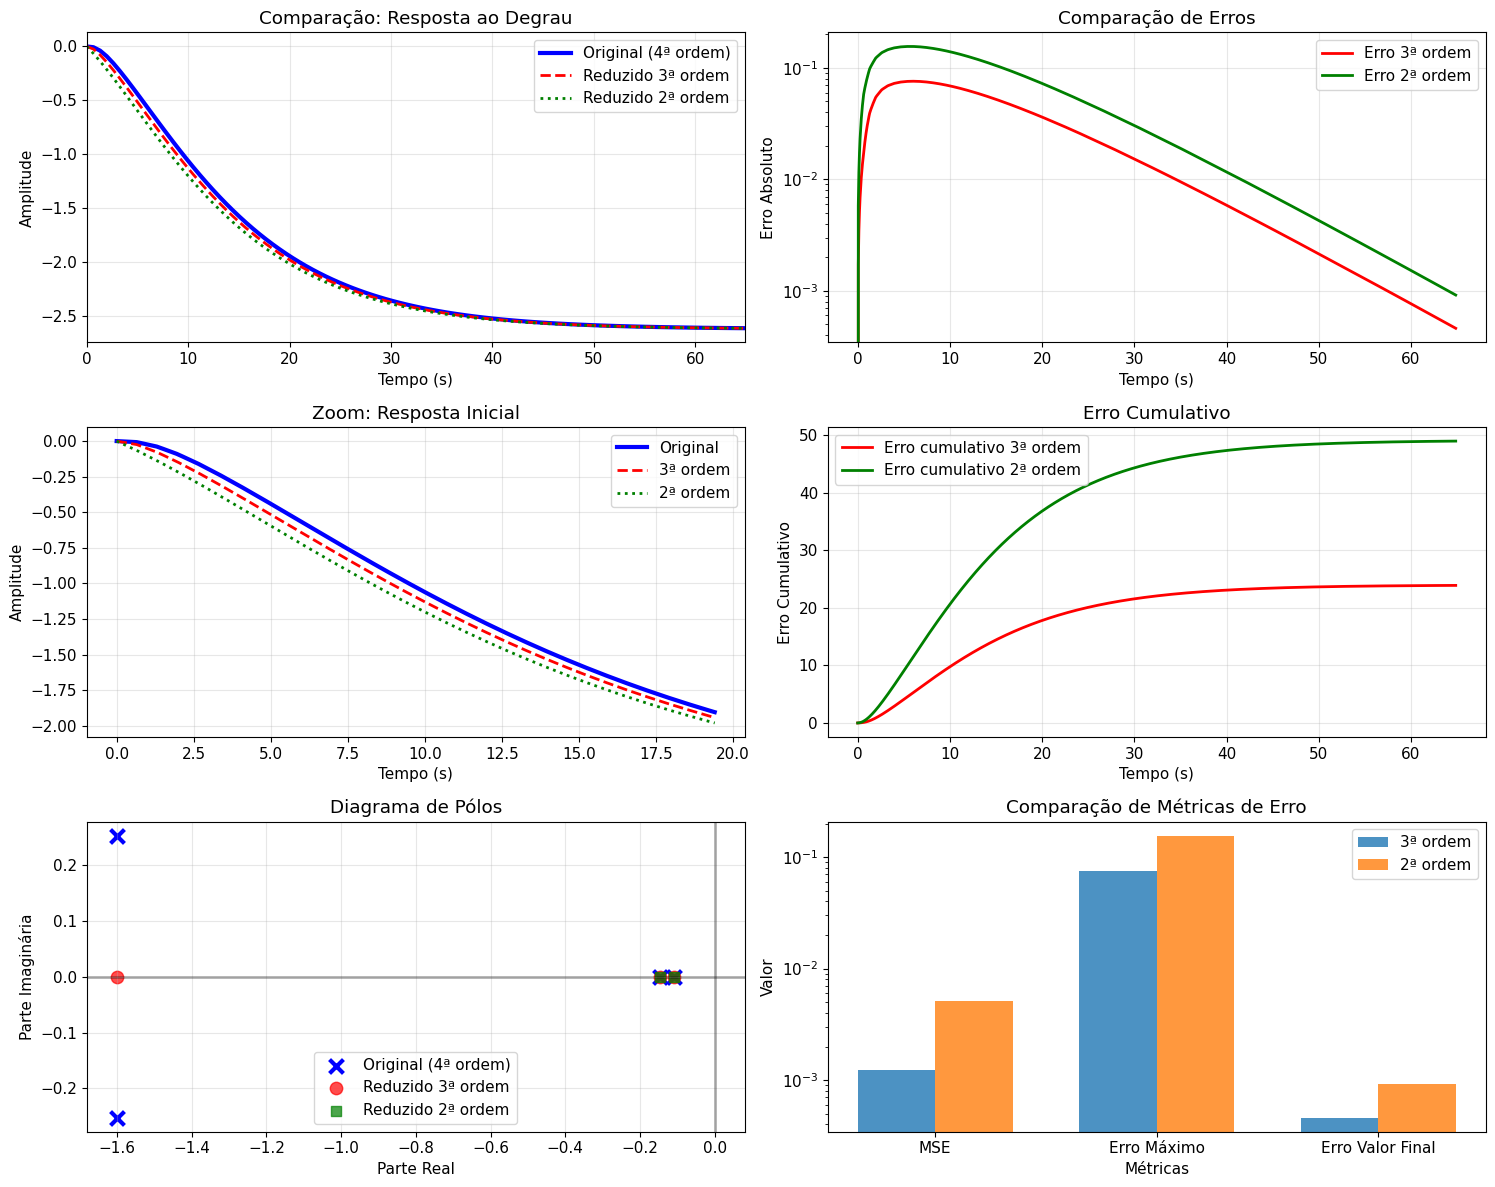

In [11]:
# Executar a análise de redução para 3ª ordem
sistema_original, sistema_3a_ordem, sistema_2a_ordem = analisar_reducao_terceira_ordem()